### Namen en studentnummers:

 **Murielle Tichelaar** (500926485)  
 **Nalini Bisessar** (500874334)  
 **Lushan Strack** (500934278)  
 **Dinand Voogt** (500934202) 

### Projectinformatie:

**Opleiding:** Toegepaste Wiskunde & Data Science  
**Vak:** Beroepsproject 3.4  
**Begeleider:** R. Nolet  
**Datum:** 20-02-2026  

### Doel/opdracht van het bestand:
In dit bestand wordt een machine‑learningpipeline ingericht om klantverloop te voorspellen. De dataset wordt eerst ingeladen en opgesplitst in features (X) en de doelvariabele (Churn). Vervolgens worden numerieke en categorische variabelen afzonderlijk voorbereid, bijvoorbeeld door middel van schaling en encoding.

Met een pipeline worden zowel de preprocessingstappen als het model samengebracht in één overzichtelijke workflow. Daarna wordt het model getraind op de trainingsset en gevalideerd op de testset. De prestaties worden beoordeeld met statistieken zoals accuracy, precision, recall en een confusion matrix.

De uiteindelijke resultaten tonen hoe effectief het model churn kan voorspellen en hoe goed het presteert op nieuwe, niet eerder gebruikte data.

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report, RocCurveDisplay
from IPython.display import display, Latex

In [2]:
# Functies
def latex_cr(cr):
    c0 = cr['0']
    c1 = cr['1']
    macro = cr['macro avg']
    weighted = cr['weighted avg']
    acc = cr['accuracy']

    output = rf"""
$$
\begin{{array}}{{lrrrr}}
\text{{}} & \text{{Precision}} & \text{{Recall}} & \text{{F1-score}} & \text{{Support}} \\\hline
0 & {c0['precision']:.2f} & {c0['recall']:.2f} & {c0['f1-score']:.2f} & {c0['support']:.0f} \\
1 & {c1['precision']:.2f} & {c1['recall']:.2f} & {c1['f1-score']:.2f} & {c1['support']:.0f} \\\hline
\text{{accuracy}} & & & {acc:.2f} & \\
\text{{macro avg}} & {macro['precision']:.2f} & {macro['recall']:.2f} & {macro['f1-score']:.2f} & {macro['support']:.0f} \\
\text{{weighted avg}} & {weighted['precision']:.2f} & {weighted['recall']:.2f} & {weighted['f1-score']:.2f} & {weighted['support']:.0f}
\end{{array}}
$$
"""
    return Latex(output)

def plot_cm(y_true, y_pred, classes=None, title="Confusion Matrix"):

    sns.set_style("white")
    plt.rcParams.update({"font.family": "DejaVu Sans", "font.size": 11})

    fig, ax = plt.subplots(figsize=(8, 5))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=classes,
        cmap="Blues",
        colorbar=True,
        ax=ax,
        include_values=False
    )

    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    threshold = cm.max() / 2

    labels = [["True Negative", "False Positive"],
              ["False Negative", "True Positive"]]

    for i in range(2):
        for j in range(2):
            value = cm[i, j]
            color = "white" if value > threshold else "#1f2937"

            ax.text(j, i-0.25, labels[i][j],
                    ha="center", fontsize=9, color=color)

            ax.text(j, i, f"{value:,}",
                    ha="center", va="center",
                    fontsize=22, fontweight="bold", color=color)

            ax.text(j, i+0.25, f"{value/total*100:.1f}%",
                    ha="center", fontsize=10, color=color)

    plt.title(title, fontsize=17, fontweight="semibold")
    plt.figtext(0.98, 0.02, f"Total samples: {total:,}",
                ha="right", fontsize=9, color="#6B7280")

    plt.tight_layout()
    plt.show()


In [3]:
# Alleen train inladen
train_path = "../../data/data_train.csv" 
df = pd.read_csv(train_path, sep=",", decimal=".")

In [4]:
# Scheiden van target en input variabelen
target = "Churn"

X = df.drop(columns=[target])
y = df[target]

X.shape, y.shape

((1995, 9), (1995,))

In [5]:
# Er is maar een categorische variabelen waar we OneHotEncoder op kunnen gebruiken namelijk Age group, 
# ookal is dit eigenlijk niet nodig omdat we ook een numerieke Age variabelen in de dataset hebben, maar de opdracht zei dat het moest...
cat_cols = ["Age Group"]
num_cols = [c for c in X.columns if c not in cat_cols]

In [6]:
# ColumnTransformer voor OneHotEncoder en StandardScaler voor de overige numerieke variabelen
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)
preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [7]:
# Hier maken we de pipline aan 
prep_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor)
])
prep_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse m

In [8]:
# Hier stoppen we X (input variabelen) in onze pipeline en leert de pipeline hoe hij deze moet schalen/encoden
X_prepared = prep_pipeline.fit_transform(X)
X_prepared.shape

(1995, 13)

We hebben nu 13 kolommen omdat door OneHotEncoder de categorische Age is omgezet naar 5 binaire kolommen.

In [9]:
# Nu voegen we Logistic Regression toe aan onze pipeline
model_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(random_state=2026))
])

model_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [10]:
# Fit het model
model_pipeline.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [11]:
# De pipeline opslaan als bestand
joblib.dump(model_pipeline, "../../data/model_pipeline.joblib")
# Model weer inladen:
# model_pipeline = joblib.load("../../data/model_pipeline.joblib")

['../../data/model_pipeline.joblib']

In [12]:
# Maken dummy model
dummy = DummyClassifier(strategy="most_frequent", random_state=2026)
dummy.fit(X, y)
y_dummy = dummy.predict(X)
proba_dummy = dummy.predict_proba(X)[:, 1]
dummy_acc = accuracy_score(y, y_dummy)


Nu hebben we het modelleren afgerond.
De volgende stap is ons model beoordelen op de trainingsdata

In [13]:
# Voorspel de kans op Churn
y_pred = model_pipeline.predict(X)
y_prob = model_pipeline.predict_proba(X)[:,1]  # kans dat Churn = 1



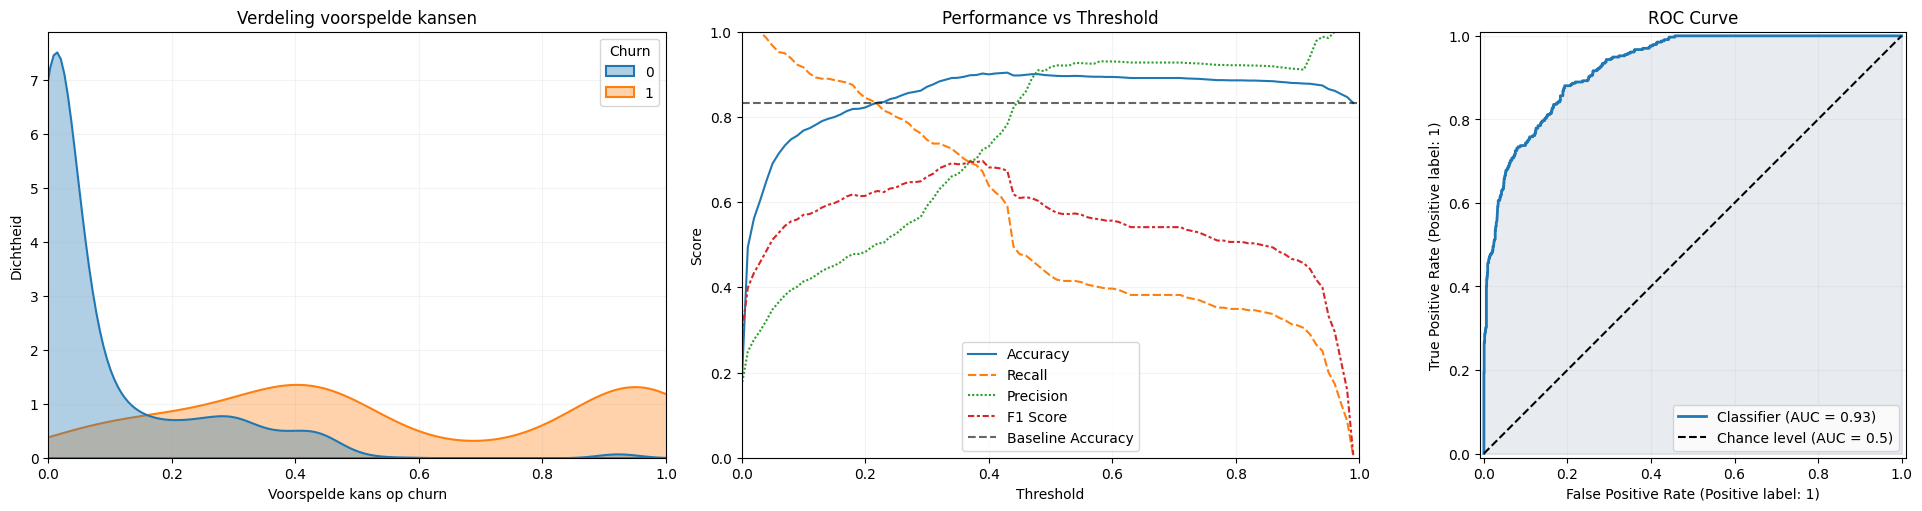

In [14]:
# 3 beschrijvende figuren
def evaluate_classification_model(y, p_pred, X, df):

    # Zet een classification report om in een rij van een dataframe
    def make_row(cr):
        return {
            'Accuracy':  cr['accuracy'],
            'Recall':    cr['1']['recall'],
            'Precision': cr['1']['precision'],
            'F1 Score':  cr['1']['f1-score']
        }

    thresholds = np.arange(0, 1, 0.01)
    plot_data = pd.DataFrame([
        make_row(classification_report(
            y, 
            p_pred > t, 
            zero_division=True, 
            output_dict=True)) for t in thresholds])
    plot_data.index = thresholds

    plt.figure(figsize=(20, 5), layout="constrained")

    # Plot 1: Distributie voorspelde kansen
    plt.subplot(1, 3, 1)
    sns.kdeplot(
        data=df,
        x=p_pred,
        hue="Churn",
        fill=True,
        common_norm=False,
        alpha=0.35,
        linewidth=1.5,

    )
    plt.xlim(0, 1)
    plt.title("Verdeling voorspelde kansen")
    plt.xlabel("Voorspelde kans op churn")
    plt.ylabel("Dichtheid")
    plt.grid(alpha=0.15)

    # Plot 2: Metrics vs threshold
    plt.subplot(1, 3, 2)
    sns.lineplot(data=plot_data)
    plt.axhline(dummy_acc, linestyle="--", linewidth=1.5, color="black", alpha=0.6, label="Baseline Accuracy")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(alpha=0.15)
    plt.title("Performance vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()

    # Plot 3: ROC curve
    ax = plt.subplot(1, 3, 3)
    roc_display = RocCurveDisplay.from_predictions(
        y,
        p_pred,
        ax=ax,
        plot_chance_level=True,
        curve_kwargs={"linewidth": 2}
    )
    plt.fill_between(roc_display.fpr, roc_display.tpr, color="#1f3b73", alpha=0.1)
    plt.title("ROC Curve")
    plt.grid(alpha=0.15)
    plt.show()
evaluate_classification_model(y, y_prob, X, df)

Verdeling voorspelde kansen
De grafiek toont de de voorspelde kans op churn voor beiden klassen. klanten die niet opzeggen krijgen een lagere voorspelde kans, terwijl klanten die wel opzeggen een hogere kans krijgen. De overlap van de grafieken geeft aan dat sommige klanten moeilijk te voorspellen zijn. 

Performance vs tresholds
Er is te zien dat in het Performance vs Threshold figuur alle 3 de metrics rond 0.35 gelijk zijn en dat daarna de precision maat stijgt in score, maar de F1 en recall juist dalen. Voor ons model wordt er gekokzen om de precision hoog te houden. Als deze laag is zou dan zijn er meer false positives en dan wordt  tarief 2 aangeboden aan klanten die normaal gesproken tarief 1 ook zouden behouden en verliezen we daardoor winst. We willen alleen tarief 2 aanbieden bij klanten die ook echt daadwerkelijk weg gaan.

De ROC Curve
Hoe dichter de ROC-curve bij de linkerbovenhoek zich bevindt, hoe beter het model presteert. Dit houdt in dat het model veel vertrekkende klanten herkent terwijl er weinig foutief worden gerekend. De AUC-waarde, de stippellijn, van 0.5 betekent dat niet beter presteert dan toeval. Terwijl een AUC van 1.0 juist aangeeft dat er een perfect model is. In dit geval ligt de AUC op 0.93, dit wilt zeggen dat het model goed onderscheid maakt tussen klanten die opzeggen en blijven.  


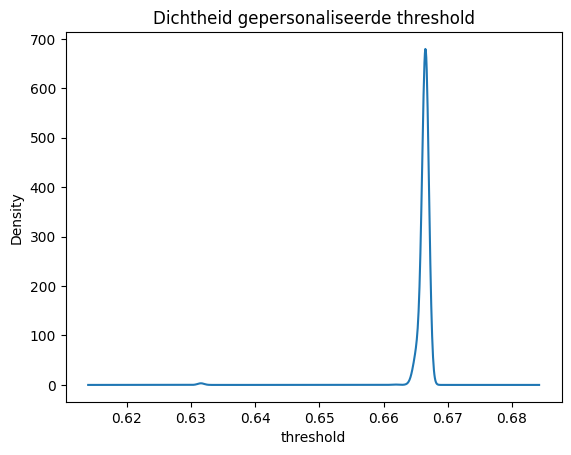

Aantal klanten tarief 2 (train): 128
Totaal aantal klanten (train): 1995


In [15]:
# Winstvergelijkingen
W1 = 0.1 * X["Frequency of SMS"] + 0.3 * X["Seconds of Use"]
W2 = 0.07 * X["Frequency of SMS"] + 0.2 * X["Seconds of Use"]

# Balansvergelijking
df["thresholds"] = (W1 - W2) / (W1 - 0.75 * W2)

# Beslissing: tarief 2 aanbieden
offer_tarief2 = (y_prob >= df["thresholds"]).astype(int)

# Density plot thresholds
df["thresholds"].plot(kind="density")
plt.title("Dichtheid gepersonaliseerde threshold")
plt.xlabel("threshold")
plt.show()

print("Aantal klanten tarief 2 (train):", int(offer_tarief2.sum()))
print("Totaal aantal klanten (train):", len(df))

Dichtheid gepersonaliseerde treshold
Uit de grafiek is te zien de thresholds van alle klanten rond de 0.665 ligt. Er wordt in ons model voor iedere klant zijn eigen threshold gebruikt, maar dit komt overeen met het kiezen van een threshold van 0.665 voor iedereen.

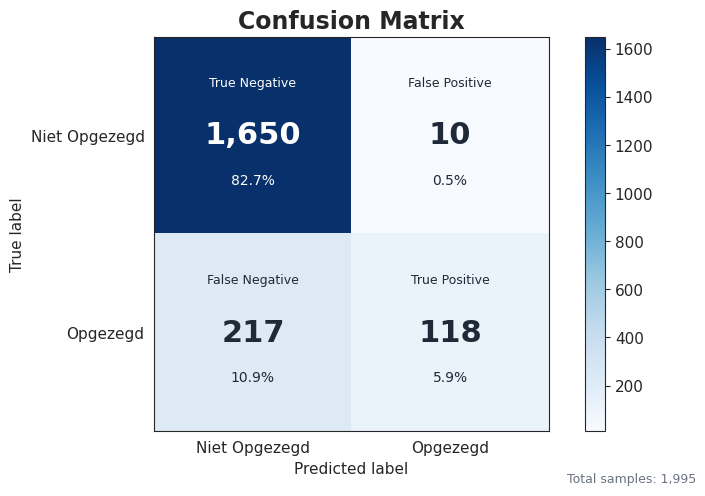

In [16]:
# Confusion matrix
class_names = ["Niet Opgezegd", "Opgezegd"] 
plot_cm(y, offer_tarief2, classes=class_names)

Confusion matrix
Van de 1995 klanten worden 1650 klanten correct als blijvend geclassificeerd. De 118 klanten worden ook correct als vertrekkend voorspeld. Het model zorgt ervoor dat er weinig klanten een onnodige aanbieding krijgen, de 10 klanten. Echter zorgt dit ervoor dat 217 klanten daadwerkelijk opzeggen. Er bestaat dus een risico dat de vertrekkende klanten niet optijd een goedkoper tarief aangeboden krijgen. 

In [17]:
display(latex_cr(classification_report(y, y_pred,  zero_division=True, output_dict=True)))

<IPython.core.display.Latex object>

Classification report 
Uit het classification report is kenbaar dat de klanten die niet vertrekken inderdaad correct worden herkent door het model. Echter is er ook te zien dat het model niet goed is in het herkennen van klanten die wel risico lopen, recall klasse 1 = 0.43. Dit betekent dat van alle klanten die vertrekken het model maar 43% hiervan vindt. Het model bespaard dus geld op het onoverbodig uitgeven van een lager tarief, maar loopt wel klanten mis die vertrekken en niet het goedkopere tarief aangeboden krijgen. De hoge accurancy komt voornamelijk doordat het model goed is in het herkennen van klanten die niet willen vertrekken. 

In [18]:
# Toevoegen aan dataframe
df["Voorspelde_kans_churn"] = y_prob
df["Tarief2_aanbieden"] = offer_tarief2

In [19]:
# Hoeveel klanten krijgen tarief 2
aantal_tarief2 = offer_tarief2.sum()
print("Aantal klanten tarief 2:", aantal_tarief2)

Aantal klanten tarief 2: 128


In [20]:
# Winst omzetten naar per maand
sms_pm = X["Frequency of SMS"] / 9
min_pm = (X["Seconds of Use"] / 60) / 9

W1_pm = 0.1 * sms_pm + 0.3 * min_pm
W2_pm = 0.07 * sms_pm + 0.2 * min_pm

# Verwachte winst per klant per maand
E_tarief1 = (1 - y_prob) * W1_pm
E_tarief2 = (1 - 0.75 * y_prob) * W2_pm

# Totale verwachte winst
totale_winst1 = E_tarief2[offer_tarief2 == 1].sum() + E_tarief1[offer_tarief2 == 0].sum()
print("Predicted:")
print("Aantal klanten tarief 2 (train):", int(offer_tarief2.sum()))
print("Totaal aantal klanten (train):", len(X))
print("Totale verwachte maandelijkse winst (train):", round(float(totale_winst1), 2))

# Baselines
print("Winst als altijd tarief 1:", round(float(E_tarief1.sum()), 2))
print("Winst als altijd tarief 2:", round(float(E_tarief2.sum()), 2))




# maximum winst per klant per maand
E_tarief1 = (1 - y) * W1_pm
E_tarief2 = (1 - 0.75 * y) * W2_pm

# Totale maximum winst 
totale_winst2 = E_tarief2[offer_tarief2 == 1].sum() + E_tarief1[offer_tarief2 == 0].sum()
print(" ")
print("Maximum:")
print("Aantal klanten tarief 2 (test):", int(y.sum()))
print("Totaal aantal klanten (test):", len(X))
print("Totale maandelijkse winst haalbaar (test):", round(float(totale_winst2), 2))
print("Verschil is rond:", round(float(totale_winst2 - totale_winst1), 2))

Predicted:
Aantal klanten tarief 2 (train): 128
Totaal aantal klanten (train): 1995
Totale verwachte maandelijkse winst (train): 6228.69
Winst als altijd tarief 1: 6206.17
Winst als altijd tarief 2: 4250.9
 
Maximum:
Aantal klanten tarief 2 (test): 335
Totaal aantal klanten (test): 1995
Totale maandelijkse winst haalbaar (test): 6233.54
Verschil is rond: 4.85


De winst is iets hoger dan wanneer we iedereen tarief 1 aanbieden, maar het verschil is klein (ongeveer €22 per maand). Dit betekent dat het goedkopere tarief maar voor een kleine groep klanten echt voordelig is. Het model vindt dus een kleine groep klanten waarbij tarief 2 nét iets meer winst oplevert. Als men de maximum haalbare winst bekijkt en vergelijkt met de verwachte winst van het gemaakte model, loop je niet veel winst mis. Het verschil is maarliefst €4,85


In [21]:
# Vergelijken met dummy model
E_tarief1_dummy = (1 - proba_dummy) * W1_pm
E_tarief2_dummy = (1 - 0.75 * proba_dummy) * W2_pm

offer_dummy = (proba_dummy >= df["thresholds"]).astype(int)

totale_winst_dummy = (
    E_tarief2_dummy[offer_dummy == 1].sum() +
    E_tarief1_dummy[offer_dummy == 0].sum()
)

print("MODEL: winst =", round(float(totale_winst1), 2),
      ": tarief2 aan", int(offer_tarief2.sum()))

print("DUMMY: winst =", round(float(totale_winst_dummy), 2),
      ": tarief2 aan", int(offer_dummy.sum()))



MODEL: winst = 6228.69 : tarief2 aan 128
DUMMY: winst = 6571.17 : tarief2 aan 0


Uit de resultaten hierboven blijkt dat het dummy model een hogere gemiddelde winst per maand heeft dan ons gemaakte logistieke regressiemodel. Dit kan betekeken dat in de huidige situatie het niet aantrekkelijk is om veel klanten tarief 2 aan te bieden. Het risico om korting te geven aan klanten die niet zouden churnen is relatief groot, waardoor het veiliger is om niemand tarief 2 aan te bieden. Het model vindt wel een kleine groep klanten waarvoor tarief 2 winstgevend lijkt, maar deze groep is niet groot genoeg om ook de totale winst te verhogen.